In [1]:
import numpy as np
import pandas as pd 
import re
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [13]:
df = pd.read_csv('train.csv')
price = df.price
df = df.drop('price', axis=1)

/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_48159/2861709684.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


### Custom Transformers

In [51]:
class CustomBoolTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that converts strings 't' and 'f' into boolean values True and False respectively,
    while leaving null values as np.nan.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = np.where(X=='t', True, np.where(X=='f', False, np.nan))
        return X_transformed
    
class DateToTimestampTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that converts date strings to timestamps.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Convert each entry in the DataFrame
        for column in X.columns:
            X[column] = X[column].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timestamp() if pd.notnull(x) else np.nan)
        return X

class PriceToFloatTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that converts strings representing prices to floats by removing the $ character and converting to float,
    while leaving null values as null.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        for column in X.columns:
            X[column] = X[column].apply(lambda x: float(x.replace('$', '')) if pd.notnull(x) else x)
        return X
    

unique_host_verifications = pd.Series(
    ', '.join(list(df.host_verifications.apply(
        lambda x: x.replace(']', '').replace('[', '').replace("'", '') \
            if x is not np.nan else '').unique())).split(','))\
    .apply(lambda x: x.replace(' ', ''))\
    .unique()
unique_host_verifications = np.delete(unique_host_verifications, 17)
def host_verifications_transformer(X):
    # unique_host_verifications = pd.Series(
    #     ', '.join(list(X.host_verifications.apply(
    #         lambda x: x.replace(']', '').replace('[', '').replace("'", '') \
    #             if x is not np.nan else '').unique())).split(','))\
    #     .apply(lambda x: x.replace(' ', ''))\
    #     .unique()
    # unique_host_verifications = np.delete(unique_host_verifications, 17)

    verified_df = {v:[] for v in unique_host_verifications}
    def word_in_string(word, string):
        pattern = r'\b{}\b'.format(re.escape(word))
        match = re.search(pattern, string)
        return bool(match)
    for verif_string in X.host_verifications:
        if type(verif_string) != str:
            for v in unique_host_verifications:
                verified_df[v].append(False)
            continue
        for v in unique_host_verifications:
            verified_df[v].append(word_in_string(v, verif_string))

    verified_df = pd.DataFrame(verified_df)
    X = X.reset_index(drop=True).merge(verified_df, left_index=True, right_index=True)
    X = X.drop(['host_verifications'], axis=1)
    return X

def one_hot_zipcodes(X):
    X['zipcode'] = X['zipcode'].apply(lambda x: str(x).replace('.0', ''))

    nyc_zip_codes = pd.read_csv('nyc-zip-codes.csv')

    z1 = X.zipcode.apply(lambda x: str(x).replace('.0', ''))

    z2 = z1.apply(lambda x: x if '-' not in x else x.split('-')[0])

    z3 = z2.apply(lambda x: x if '\n' not in x else x.split('\n')[0])

    def zip_to_int(zipcode):
        try: return int(zipcode)
        except: return np.nan

    int_zips = z3.apply(zip_to_int)

    valid_zips = int_zips.apply(
        lambda x: x if sum(x==nyc_zip_codes.ZipCode)>=1 else np.nan)

    one_hot_zipcodes = pd.get_dummies(valid_zips)
    one_hot_zipcodes = one_hot_zipcodes.reindex(columns=nyc_zip_codes.ZipCode, fill_value=0)

    X = X.reset_index(drop=True) \
        .merge(one_hot_zipcodes, left_index=True, right_index=True)
    X = X.drop(['zipcode'], axis=1)
    return X


amenities_list = df['amenities'].str.replace('{', '')
amenities_list = amenities_list.str.replace('}', '')
amenities_list = amenities_list.str.replace('"', '').str.split(',')
unique_amenities = set([item for sublist in amenities_list for item in sublist])
def transform_amenities(X):
    def create_amenities_df(X):
        # amenities_list = X['amenities'].str.replace('{', '')
        # amenities_list = amenities_list.str.replace('}', '')
        # amenities_list = amenities_list.str.replace('"', '').str.split(',')
        # unique_amenities = set([item for sublist in amenities_list for item in sublist])
        
        amenities_df = {}
        for amenity in unique_amenities:
            amenities_df[amenity] = X['amenities'].apply(lambda x: amenity in x)
        
        return pd.DataFrame(amenities_df)
    
    amenities_df = create_amenities_df(X)

    X = X.reset_index(drop=True) \
        .merge(amenities_df, left_index=True, right_index=True)
    X = X.drop(['amenities'], axis=1)

    return X

enc = OneHotEncoder(handle_unknown='ignore').fit(df[one_hot_features])
class PretrainedOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer for one hot encoding based on training data.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return enc.transform(X)
        


### Preprocessing 

In [52]:
date_features = ['host_since', 'first_review', 'last_review']

bool_features = [
    'require_guest_phone_verification', 'require_guest_profile_picture', 
    'is_business_travel_ready', 'instant_bookable', 
    'host_identity_verified', 'host_has_profile_pic', 'host_is_superhost'
]

one_hot_features = [
    'room_type', 'neighbourhood_group_cleansed', 'bed_type', 
    'host_response_time', 'cancellation_policy', 'property_type',
    'neighbourhood_cleansed'
]

numeric_cols_no_nulls = [
    'host_id', 'accommodates', 'number_of_reviews', 'maximum_nights', 
    'minimum_nights', 'guests_included', 'calculated_host_listings_count'
] 

# Some of these are missing many more values than others and could probably be 
# imputed better.
numeric_needs_impute = [
    'host_listings_count', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
]

# non_date_columns = [col for col in df.columns if col not in date_features]
# non_bool_columns = [col for col in df.columns if col not in bool_features]
# non_onehot_columns = [col for col in df.columns if col not in one_hot_features]

cols_used = (
    date_features + bool_features 
    #+ one_hot_features
    + ['zipcode'] 
    + ['extra_people'] 
    + ['amenities'] 
    + ['host_verifications']
    + numeric_cols_no_nulls + numeric_needs_impute
)

unused_cols = [col for col in df.columns if col not in cols_used]

boolean_pipeline = Pipeline(steps=[
    ('bool_transform', CustomBoolTransformer()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=False))
])

date_pipeline = Pipeline(steps=[
    ('bool_transform', DateToTimestampTransformer()),
    ('imputer', IterativeImputer())
])


one_hot_pipeline = Pipeline(steps=[
    ('one_hot_encoding', PretrainedOneHotEncoder()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=False))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', unused_cols),
        ('one_hot_encoding', one_hot_pipeline, one_hot_features),
        ('one_hot_zipcodes', FunctionTransformer(one_hot_zipcodes), ['zipcode']),
        ('transform_amenities', FunctionTransformer(transform_amenities), ['amenities']),
        ('host_verifications_transform', FunctionTransformer(host_verifications_transformer), ['host_verifications']),
        ('numeric_to_float', PriceToFloatTransformer(), ['extra_people']),
        ('bool_transform', boolean_pipeline, bool_features),
        ('date_transform', date_pipeline, date_features),
        ('numeric_transform', numeric_pipeline, numeric_needs_impute)
    ], remainder='passthrough')


airbnb_preprocess = Pipeline(steps=[('preprocessor', preprocessor)])

df_cleaned = airbnb_preprocess.fit_transform(df)
df_cleaned

array([[1.0, 0.0, 0.0, ..., 12, 6, 1],
       [1.0, 0.0, 0.0, ..., 30, 137, 3],
       [1.0, 0.0, 0.0, ..., 1125, 3, 1],
       ...,
       [0.0, 1.0, 0.0, ..., 365, 0, 1],
       [0.0, 1.0, 0.0, ..., 1125, 1, 3],
       [1.0, 0.0, 0.0, ..., 120, 56, 1]], dtype=object)

#### Tests

In [59]:
rejected_cols = [
    'id', 'price', 'host_acceptance_rate', 'square_feet', 'host_response_rate',
    'city', 'state', 'market', 'country_code', 'country', 'host_name', 'name',
    
]
cols_left_over = [col for col in unused_cols if col not in rejected_cols]
cols_left_over

['summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_location',
 'host_about',
 'host_neighbourhood',
 'host_verifications',
 'zipcode',
 'amenities',
 'extra_people']

/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_47903/4235689606.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_values.values, y=missing_values.index, palette='rocket')
/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_47903/4235689606.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(missing_values[i], i, f'{missing_values[i]*100:.2f}%', ha='left', va='center')


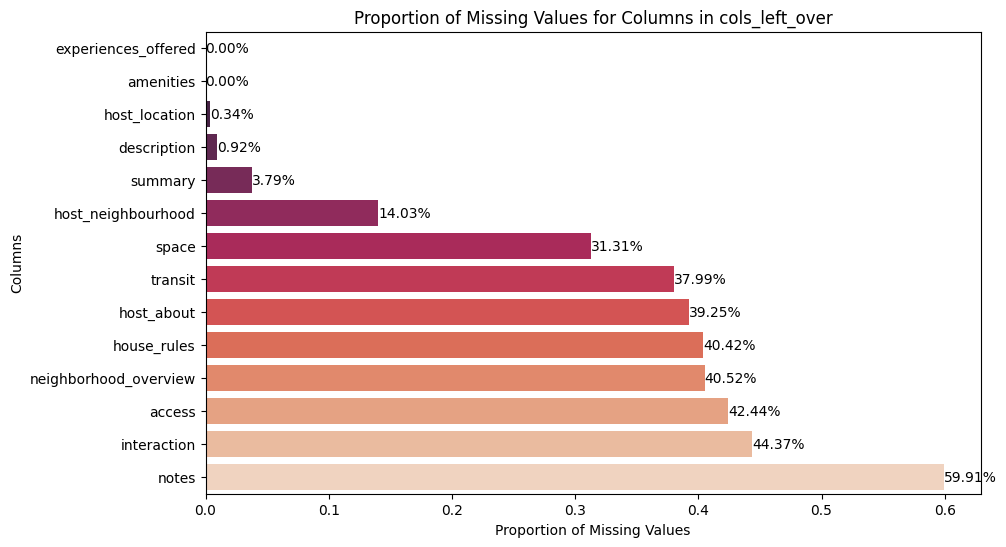

In [19]:
# Visualizes the proportion of missing values for columns in cols_left_over using a bar plot
import seaborn as sns

missing_values = df[cols_left_over].isnull().mean().sort_values()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=missing_values.values, y=missing_values.index, palette='rocket')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Columns')
plt.title('Proportion of Missing Values for Columns in cols_left_over')

for i in range(len(missing_values)):
    ax.text(missing_values[i], i, f'{missing_values[i]*100:.2f}%', ha='left', va='center')

plt.show()

In [26]:
df['amenities'][0]

'{Wifi,"Air conditioning",Kitchen,Gym,Breakfast,Elevator,Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Building staff","Hot water","Luggage dropoff allowed"}'

In [32]:
amenities_list = df['amenities'].str.replace('{', '')
amenities_list = amenities_list.str.replace('}', '')
amenities_list = amenities_list.str.replace('"', '')
amenities_list[1]

'TV,Internet,Wifi,Air conditioning,Kitchen,Paid parking off premises,Free street parking,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Dryer,Smoke detector,Carbon monoxide detector,First aid kit,Fire extinguisher,Essentials,Shampoo,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace,Private entrance,Hot water,Bed linens,Extra pillows and blankets,Microwave,Coffee maker,Refrigerator,Dishes and silverware,Cooking basics,Oven,Stove,Long term stays allowed,Host greets you'

In [38]:

# Function to create a new dataframe from the 'amenities' column
def transform_amenities(X):
    def create_amenities_df(X):
        amenities_list = X['amenities'].str.replace('{', '')
        amenities_list = amenities_list.str.replace('}', '')
        amenities_list = amenities_list.str.replace('"', '').str.split(',')
        unique_amenities = set([item for sublist in amenities_list for item in sublist])
        
        amenities_df = {}
        for amenity in unique_amenities:
            amenities_df[amenity] = X['amenities'].apply(lambda x: amenity in x)
        
        return pd.DataFrame(amenities_df)
    
    amenities_df = create_amenities_df(X)

    X = X.reset_index(drop=True) \
        .merge(amenities_df, left_index=True, right_index=True)
    X = X.drop(['amenities'], axis=1)

    return X


In [36]:
numeric_unused_cols = [col for col in unused_cols if df[col].dtype in ['int64', 'float64']]
df[numeric_unused_cols].isna().sum().sort_values()



id                          0
price                       0
square_feet             33197
host_acceptance_rate    33538
dtype: int64

In [55]:
# Count the number of nulls for each feature in df_cleaned
null_counts = pd.DataFrame(df_cleaned).isnull().sum()
print("Null counts for each feature in df_cleaned:\n", null_counts.sum())



Null counts for each feature in df_cleaned:
 0


### Model Building 

In [53]:
from sklearn.model_selection import train_test_split

X = df_cleaned
y = price

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (26830, 627)
X_test shape: (6708, 627)
y_train shape: (26830,)
y_test shape: (6708,)


In [54]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

# Create an XGBoost regressor (or classifier based on your problem)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Calculate the training RMSE (Root Mean Squared Error)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
print("Training RMSE:", train_rmse)

# Optionally, make predictions on the testing data
y_test_pred = model.predict(X_test)

# Calculate the testing RMSE (Root Mean Squared Error)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print("Testing RMSE:", test_rmse)

Training RMSE: 51.07273878635044
Testing RMSE: 88.33428300440447


In [57]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Create an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Perform Grid Search with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Parameters:", best_params)
print("Best Score (RMSE):", (-best_score)**0.5)

# Train the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the testing data using the best model
y_test_pred = best_model.predict(X_test)

# Calculate the testing RMSE with the best model
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Testing RMSE with Best Model:", test_rmse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Score (RMSE): 84.06846574532067
Testing RMSE with Best Model: 87.1256014540916


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Run Predictions

In [58]:
unlabled_df = pd.read_csv('test.csv')
unlabled_df_cleaned = airbnb_preprocess.fit_transform(unlabled_df)
# unlabled_df_cleaned = unlabled_df_cleaned.reindex(columns=df_cleaned.columns, fill_value=False)

unlabled_predictions = pd.DataFrame().assign(
    Id = unlabled_df.id,
    Predicted = best_model.predict(unlabled_df_cleaned)
)
unlabled_predictions

/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_48159/1937014264.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  unlabled_df = pd.read_csv('test.csv')


,Id,Predicted
0,19307997,376.861115
1,20176193,126.403358
2,19485371,37.054535
3,13079990,62.527893
4,22339757,45.777748
...,...,...
17332,22325617,76.404289
17333,8372650,351.809967
17334,3812554,91.359039
17335,18891508,49.471432


In [59]:
unlabled_predictions.to_csv('submission2.csv', index=False)

